# AquaYOLO model for Underwater Object Detection

This is a replication of the model/architecture purposed in **AquaYOLO: Enhancing YOLOv8 for Accurate Underwater Object Detection for Sonar Images**. The paper can be found at [this link](https://www.mdpi.com/2077-1312/13/1/73). 

## Dataset Setup

Using the UATD dataset:

- Download the dataset from [here](hhttps://figshare.com/articles/dataset/UATD_Dataset/21331143/3). Download all 4 zips.
- Create ./data folder within the model. (Like this: ./aqua_yolo/data)
- Place the downloaded .zip files inside the data-folder
- Then unzip them manually or running code below:

In [1]:
import zipfile
import os

zip_paths = ["data/UATD_OpenSLT.zip", "data/UATD_Test_1.zip", "data/UATD_Test_2.zip", "data/UATD_Training.zip",]
extract_dir = "data/UATD/"

# Make sure the target directory exists
os.makedirs(extract_dir, exist_ok=True)

for zip_path in zip_paths:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(zip_path, " extracted to:", os.path.abspath(extract_dir))

data/UATD_OpenSLT.zip  extracted to: /Users/henrik/kode/SP/aqua_yolo/data/UATD
data/UATD_Test_1.zip  extracted to: /Users/henrik/kode/SP/aqua_yolo/data/UATD
data/UATD_Test_2.zip  extracted to: /Users/henrik/kode/SP/aqua_yolo/data/UATD
data/UATD_Training.zip  extracted to: /Users/henrik/kode/SP/aqua_yolo/data/UATD


### Setup on YOLO format

### Now lets vizualise some data:


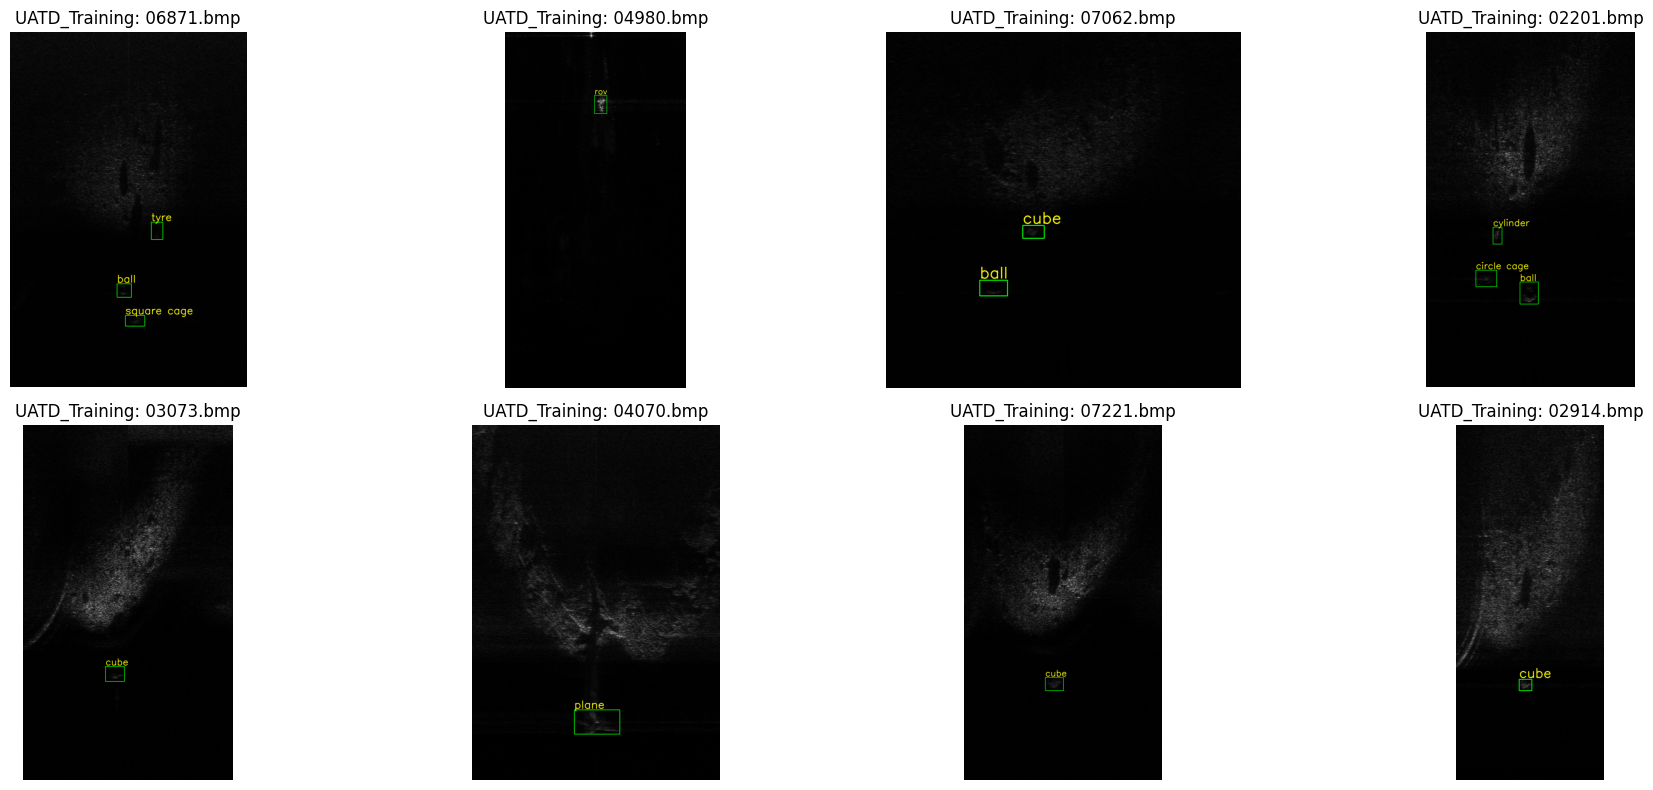

In [ ]:
# --- UATD CV2 visualizer ------------------------------------------------------
import os, math, random, re
from pathlib import Path
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt

# ---------------- config ----------------
UATD_ROOT = Path("data/UATD")
SUBSET    = "UATD_Training"   # "UATD_Test_1", "UATD_Test_2" also valid

IMG_DIR = UATD_ROOT / SUBSET / "images"
ANN_DIR = UATD_ROOT / SUBSET / "annotations"

NUM_PICS = 8
COLS = 4
# ----------------------------------------

def find_images(folder: Path):
    exts = (".bmp", ".jpg", ".jpeg", ".png", ".tif", ".tiff")
    return [p for p in folder.rglob("*") if p.suffix.lower() in exts]

def xml_path_for(img_path: Path) -> Path:
    # XMLs have the same stem as the image (e.g., 00001.xml)
    return ANN_DIR / f"{img_path.stem}.xml"

# --- robust numeric extractor for fields like '12(+/-6)' or '1200k' ----------
_num_pat = re.compile(r'[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?')
def safe_float(s):
    if s is None: return None
    m = _num_pat.search(str(s))
    return float(m.group()) if m else None

# --- parse UATD XML (boxes + optional meta) ----------------------------------
def parse_uatd_xml(xml_file: Path):
    """
    Returns: dict(image_id, width, height, objects=[{name,xmin,ymin,xmax,ymax},...], meta=dict)
    """
    root   = ET.parse(xml_file).getroot()
    width  = int(float(root.findtext("size/width")))
    height = int(float(root.findtext("size/height")))

    objs = []
    for obj in root.findall("object"):
        name = (obj.findtext("name") or "").strip()
        bb   = obj.find("bndbox")
        xmin = int(float(bb.findtext("xmin")))
        ymin = int(float(bb.findtext("ymin")))
        xmax = int(float(bb.findtext("xmax")))
        ymax = int(float(bb.findtext("ymax")))
        objs.append(dict(name=name, xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax))

    meta = dict(
        range      = safe_float(root.findtext("sonar/range")),
        azimuth    = safe_float(root.findtext("sonar/azimuth")),
        elevation  = safe_float(root.findtext("sonar/elevation")),
        soundspeed = safe_float(root.findtext("sonar/soundspeed")),
        frequency  = root.findtext("sonar/frequency"),
        frequency_hz = safe_float(root.findtext("sonar/frequency")),
    )
    return dict(
        image_id=xml_file.stem, width=width, height=height, objects=objs, meta=meta
    )

# --- draw boxes with cv2 ------------------------------------------------------
def draw_voc_boxes(image_bgr, ann_xml: Path):
    """
    Draw VOC boxes and labels from a UATD XML onto a BGR image and return an RGB image.
    """
    img = image_bgr.copy()
    h, w = img.shape[:2]
    if not ann_xml.exists():
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    try:
        ann = parse_uatd_xml(ann_xml)
    except Exception as e:
        # If a weird XML slips through, just show the raw image.
        print(f"Failed to parse {ann_xml}: {e}")
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for o in ann["objects"]:
        x1, y1, x2, y2 = o["xmin"], o["ymin"], o["xmax"], o["ymax"]
        # clamp to image bounds
        x1 = max(0, min(w-1, x1)); y1 = max(0, min(h-1, y1))
        x2 = max(0, min(w-1, x2)); y2 = max(0, min(h-1, y2))

        # green box with yellow label (like your example)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
        label = o["name"] or "obj"
        cv2.putText(img, label, (x1, max(0, y1-6)),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,255), 2, cv2.LINE_AA)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- collect images & visualize ----------------------------------------------
all_imgs = find_images(IMG_DIR)
imgs_with_xml = [p for p in all_imgs if xml_path_for(p).exists()]
pool = imgs_with_xml if imgs_with_xml else all_imgs
if not pool:
    raise FileNotFoundError(f"No images found in {IMG_DIR}")

sample_imgs = random.sample(pool, min(NUM_PICS, len(pool)))
rows = math.ceil(len(sample_imgs) / COLS)

plt.figure(figsize=(5*COLS, 4*rows))
for i, img_path in enumerate(sample_imgs, 1):
    bgr = cv2.imread(str(img_path))
    if bgr is None:
        print(f"Could not read {img_path}")
        continue
    vis = draw_voc_boxes(bgr, xml_path_for(img_path))

    plt.subplot(rows, COLS, i)
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"{SUBSET}: {img_path.name}")
plt.tight_layout(); plt.show()
# ----------------------------------------------------------------------------- 
